# Stochastic Gradient Descent for 2-Layer Neural Network from Scratch

## Building the objects we need : Module (=perceptron) , Loss

In [4]:
import numpy as np
import random

def load_mnist(filename):
    with open(filename,"r") as f:
        f.readline()
        data =[ [float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp = np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)


class Module:
    def forward(self,x):
        pass
    def backward_updateGradient(self,x,delta):
        pass
    def zeroGradParameters(self):
        pass
    def backward_delta(self, x , delta):
        pass
    def updateParameters(self,learning_rate):
        pass
    def zeroGradParameters(self,learnin_rate):
        pass
    
    
class Loss :
    def getLossValue (self, ypredit ,y):
        pass
    def backward(self,ypredit,y):
        pass
    
    
class SquareLoss(Loss) :
    def __init__(self,dimension):
        self.dimension=dimension #nombre de points que l'on compare
        
    def getLossValue (self, y_predit,y):
        loss = 0.0
        for k in range(0,self.dimension) :
            loss += (y_predit[k]-y[k])**2
        loss /= self.dimension
        return loss
    
    def backward(self,y_predit, y):
        #dérivé par rapport à ypred, donc de taille self.dimension
        grad = np.zeros(self.dimension)
        for k in range(0,self.dimension):
            grad[k] = 2/self.dimension*(y_predit[k]-y[k])
        return grad
            
        
class TanHModule(Module):
    def __init__(self,dimension):
        self.X = dimension
    
    def forward(self,x):
        result = np.zeros(self.X)
        for i in range(0,self.X):
            result[i] = np.tanh(x[i])
        return result
    
    def zeroGradParameters(self):
        self.grad = np.zeros((self.X,self.Y))
    
    def backward_delta(self, x , delta):    
        #grad du Loss par rapport à x. Donc de taille n
        grad_x = np.zeros(self.X)
        for i in range(0,self.X):
            grad_x[i] += delta[i]*(1 - np.tanh(x[i])**2)
        return grad_x
   
 
class LinearModule(Module):
    def __init__(self,n,C):
        self.X = n #input_dimension
        self.Y = C #ouput_dimension
        self.theta = np.zeros((self.X,self.Y)) #vecteur des paramètres
        self.grad = np.zeros((self.X,self.Y)) #vecteur du grad
        
    def zeroGradParameters(self):
        self.grad = np.zeros((self.X,self.Y)) #mettre le grad à zero

    def forward(self,x):
        result = np.dot(x,self.theta)
        return result
    
    def randomize(self, variance):
        for i in range(0,self.X):
            for j in range(0,self.Y):
                self.theta[i][j]= random.uniform(-variance,variance)
        
    def backward_updateGradient(self,x,delta):
        #gradient du loss par rapport à theta. Donc de même dimension que théta. n x c
        for i in range(0,self.X):
            for j in range(0,self.Y):
                self.grad[i][j] += delta[j]*x[i]
    
    def updateParameters(self,learning_rate):
        self.theta = self.theta - learning_rate*self.grad
        
    def backward_delta(self, x , delta):    
        #grad du Loss par rapport à x. Donc de taille n
        grad_x = np.zeros(self.X)
        for i in range(0,self.X):
            for k in range(0,self.Y):
                grad_x[i] += delta[k]*self.theta[i,k]
        return grad_x

## Getting the data

In [5]:
from sklearn.cross_validation import KFold, train_test_split

def load_mnist(filename):
    with open(filename,"r") as f:
        f.readline()
        data =[ [float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp = np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

data = load_mnist('../USPS_train.txt')
data_real = np.concatenate((np.asmatrix(data[0]),np.transpose(np.asmatrix(data[1]))),axis=1)

x_train, x_test, y_train_0, y_test_0 = train_test_split(np.asarray(data_real[:,0:256]),np.asarray(data_real[:,256])
                                                    , test_size=0.33,random_state=42)


y_train =(-1)*np.zeros((len(x_train),10))
for i in range(0,len(x_train)):
    p= int(y_train_0[i])
    y_train[i][p]=1

y_test =(-1)*np.zeros((len(x_test),10))
for i in range(0,len(x_test)):
    p= int(y_test_0[i])
    y_test[i][p]=1

## Creating the objects and defining the parameters

In [6]:
m1 = LinearModule(256,500)
m1.randomize(0.01)

tanh_1=TanHModule(500) #500 en entrée et en sortie

m2 = LinearModule(500,10)
m2.randomize(0.01)

tanh_2=TanHModule(10) #10 en entrée et en sortie

def all_function(x):
    return tanh_2.forward(m2.forward(tanh_1.forward(m1.forward(x))))

criterion = SquareLoss(10)
learning_rate= 0.1 
maxEpoch = 100

all_losses_global_train=np.zeros(maxEpoch)
all_losses_global_test=np.zeros(maxEpoch)
all_out =np.zeros(maxEpoch)
accuracy_train=np.zeros(maxEpoch)
accuracy_test=np.zeros(maxEpoch)

## Stochastic Gradient Descent

In [7]:
import time
time_started = time.time()

for iteration in range(0,maxEpoch) : 
    j=random.randint(0,len(x_train)-1)
    m1.zeroGradParameters()
    m2.zeroGradParameters()
    x=x_train[j] #(256)
    y=y_train[j] #(10)
    out_1 = m1.forward(x) #value with model 1 (#500)
    out_2 = tanh_1.forward(out_1) #with activation tanh 1 (#500)
    out_3 = m2.forward(out_2) #then propagated to model 2 (#10)
    out_4 = tanh_2.forward(out_3) #with activation tanh 2 (#10)
    
    loss=criterion.getLossValue(out_4,y) #loss between y_prédit et y (1)
    delta=criterion.backward(out_4,y)   #loss to propagate (10)
    
    tanh_2.backward_updateGradient(out_3,delta)  #doesn't do anything because there is no parameter
    delta_1 = tanh_2.backward_delta(out_3,delta) #loss to propagate (10)

    m2.backward_updateGradient(out_2,delta_1)  #update le gradient 
    delta_2 = m2.backward_delta(out_2,delta_1) #loss to propagate (500)
    
    tanh_1.backward_updateGradient(out_1,delta_2)  #doesn't do anything because there is no parameter
    delta_3 = tanh_1.backward_delta(out_1,delta_2) #loss to propagate

    m1.backward_updateGradient(x,delta_3) #updating gradient
    delta_4 = m1.backward_delta(x,delta_3) #doesn't do anything because there is no parameter because no model before
    
###backpropagation is over, let's upgrade modules' parameters
    m1.updateParameters(learning_rate)
    tanh_1.updateParameters(learning_rate) #ne fait rien puisque tanh n'a pas de parametre
    m2.updateParameters(learning_rate)
    tanh_2.updateParameters(learning_rate) #ne fait rien puisque tanh n'a pas de parametre

###Losses & Accuracy
    all_losses_global_train[iteration] = 0
    for k in range(0,len(x_train)):
        all_losses_global_train[iteration] += criterion.getLossValue(all_function(x_train[k]),y_train[k])/len(x_train)
    
    all_losses_global_test[iteration] = 0
    for k in range(0,len(x_test)):
        all_losses_global_test[iteration] += criterion.getLossValue(all_function(x_test[k]),y_test[k])/len(x_test)
    
    accuracy_train[iteration] = 0
    for k in range(0,len(x_train)):
        accuracy_train[iteration] += (np.argmax(all_function(x_train[k]))==np.argmax(y_train[k]))*1/len(x_train)
         
    accuracy_test[iteration] = 0
    for k in range(0,len(x_test)):
        accuracy_test[iteration] += (np.argmax(all_function(x_test[k]))==np.argmax(y_test[k]))*1/len(x_test)

time_finished = time.time()

KeyboardInterrupt: 

## Results for Stochastic gradient descent  

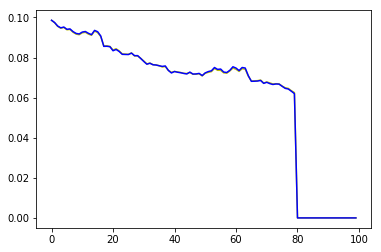

In [9]:
import matplotlib.pyplot as plt
plt.plot(all_losses_global_train,'y')
plt.plot(all_losses_global_test,'b')
plt.show()

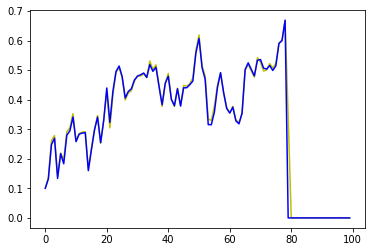

In [10]:
plt.plot(accuracy_train,'y')
plt.plot(accuracy_test,'b')
plt.show()

In [11]:
#Time taken 
print(f'The Stochastic Gradient Descent took {time_finished-time_started:.2f} seconds')
print(f'Last Accuracy on train/test were {accuracy_train[-1]*100:.2f}% / {accuracy_test[-1]*100:.2f}% ')
print(f'Last Loss on train/test were {all_losses_global_train[-1]*100:.2f} / {all_losses_global_test[-1]*100:.2f} ')

NameError: name 'time_finished' is not defined

## Gradient Descent on only 100 observations

In [15]:
np.random.shuffle(data_real) #Suffle the dat
data_real=data_real[0:100] #Selecting only 100 observations

x_train, x_test, y_train_0, y_test_0 = train_test_split(np.asarray(data_real[:,0:256]),np.asarray(data_real[:,256])
                                                    , test_size=0.33,random_state=42)


y_train =(-1)*np.zeros((len(x_train),10))
for i in range(0,len(x_train)):
    p= int(y_train_0[i])
    y_train[i][p]=1

y_test =(-1)*np.zeros((len(x_test),10))
for i in range(0,len(x_test)):
    p= int(y_test_0[i])
    y_test[i][p]=1

In [16]:
m1 = LinearModule(256,500)
m1.randomize(0.01)

tanh_1=TanHModule(500) #500 en entrée et en sortie

m2 = LinearModule(500,10)
m2.randomize(0.01)

tanh_2=TanHModule(10) #10 en entrée et en sortie

def all_function(x):
    return tanh_2.forward(m2.forward(tanh_1.forward(m1.forward(x))))

criterion = SquareLoss(10)
learning_rate= 0.1 
maxEpoch = 100

all_losses_global_train_2=np.zeros(maxEpoch)
all_losses_global_test_2=np.zeros(maxEpoch)
all_out =np.zeros(maxEpoch)
accuracy_train_2=np.zeros(maxEpoch)
accuracy_test_2=np.zeros(maxEpoch)

In [17]:
import time
time_started = time.time()

for iteration in range(0,maxEpoch) : 
    j=random.randint(0,len(x_train)-1)
    m1.zeroGradParameters()
    m2.zeroGradParameters()
    x=x_train[j] #(256)
    y=y_train[j] #(10)
    out_1 = m1.forward(x) #value with model 1 (#500)
    out_2 = tanh_1.forward(out_1) #with activation tanh 1 (#500)
    out_3 = m2.forward(out_2) #then propagated to model 2 (#10)
    out_4 = tanh_2.forward(out_3) #with activation tanh 2 (#10)
    
    loss=criterion.getLossValue(out_4,y) #loss between y_prédit et y (1)
    delta=criterion.backward(out_4,y)   #loss to propagate (10)
    
    tanh_2.backward_updateGradient(out_3,delta)  #doesn't do anything because there is no parameter
    delta_1 = tanh_2.backward_delta(out_3,delta) #loss to propagate (10)

    m2.backward_updateGradient(out_2,delta_1)  #update le gradient 
    delta_2 = m2.backward_delta(out_2,delta_1) #loss to propagate (500)
    
    tanh_1.backward_updateGradient(out_1,delta_2)  #doesn't do anything because there is no parameter
    delta_3 = tanh_1.backward_delta(out_1,delta_2) #loss to propagate

    m1.backward_updateGradient(x,delta_3) #updating gradient
    delta_4 = m1.backward_delta(x,delta_3) #doesn't do anything because there is no parameter because no model before
    
###backpropagation is over, let's upgrade modules' parameters
    m1.updateParameters(learning_rate)
    tanh_1.updateParameters(learning_rate) #ne fait rien puisque tanh n'a pas de parametre
    m2.updateParameters(learning_rate)
    tanh_2.updateParameters(learning_rate) #ne fait rien puisque tanh n'a pas de parametre

###Losses & Accuracy
    all_losses_global_train[iteration] = 0
    for k in range(0,len(x_train)):
        all_losses_global_train[iteration] += criterion.getLossValue(all_function(x_train[k]),y_train[k])/len(x_train)
    
    all_losses_global_test[iteration] = 0
    for k in range(0,len(x_test)):
        all_losses_global_test[iteration] += criterion.getLossValue(all_function(x_test[k]),y_test[k])/len(x_test)
    
    accuracy_train[iteration] = 0
    for k in range(0,len(x_train)):
        accuracy_train[iteration] += (np.argmax(all_function(x_train[k]))==np.argmax(y_train[k]))*1/len(x_train)
         
    accuracy_test[iteration] = 0
    for k in range(0,len(x_test)):
        accuracy_test[iteration] += (np.argmax(all_function(x_test[k]))==np.argmax(y_test[k]))*1/len(x_test)

time_finished = time.time()

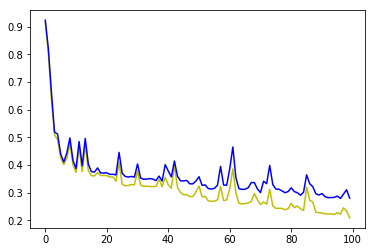

In [18]:
import matplotlib.pyplot as plt
plt.plot(all_losses_global_train_2,'y')
plt.plot(all_losses_global_test_2,'b')
plt.show()

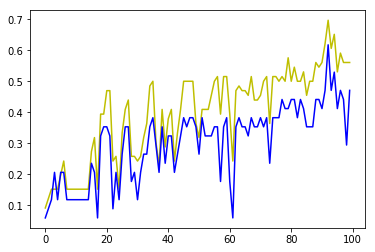

In [19]:
plt.plot(accuracy_train_2,'y')
plt.plot(accuracy_test_2,'b')
plt.show()

In [ ]:
#Time taken 
print(f'The Stochastic Gradient Descent took {time_finished-time_started:.2f} seconds')
print(f'Last Accuracy on train/test were {accuracy_train[-1]*100:.2f}% / {accuracy_test[-1]*100:.2f}% ')
print(f'Last Loss on train/test were {all_losses_global_train[-1]*100:.2f} / {all_losses_global_test[-1]*100:.2f} ')